# **Mithila ART CLASSIFICATION MODEL**

## Install Necessary Dependencies

In [ ]:
# !pip install tensorflow keras numpy matplotlib scikit-learn opencv-python
# !pip install pillow

  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
Using cached eval_type_backport-0.2.0-py3-none-any.whl (5.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.1/633.1 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.13
    Uninstalling albucore-0.0.13:
      Successfully uninstalled albucore-0.0.13
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.10
    Uninstalling albumentations-1.4.10:
      Successfully uninstalled albumentations-1.4.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleocr 2.9.1 requires albucore==0.0.13, but you have albucore 0.0.20 which is incompatible.
paddleocr 2.9.1 requires albumentations==1.4.10, but you have albumentations 1.4.21 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 2

In [ ]:
import os
import shutil
import albumentations as A
import cv2
from collections import defaultdict
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [3]:
image_labels = [
  "Mandala Art",
  "Mithila Painting",
  "Paubha Painting",
  "Thangka Painting"
]


In [10]:

def count_images_in_subfolders(base_dir):
    """
    Counts the number of images in each class subfolder for train, val, and test splits.
    """
    split_counts = defaultdict(dict)

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path):
            continue
        
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            
            image_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            split_counts[split][class_name] = image_count
    
    return split_counts

# Example usage
dataset_base_dir = "./augmented-dataset"
split_counts = count_images_in_subfolders(dataset_base_dir)

# Display the counts
for split, counts in split_counts.items():
    print(f"{split.capitalize()} split:")
    for class_name, count in counts.items():
        print(f"  {class_name}: {count} images")


Train split:
  Mithila Painting: 10860 images
  Thangka Painting: 8130 images
  Mandala Art: 7800 images
  Paubha Painting: 7050 images
Val split:
  Mithila Painting: 2325 images
  Thangka Painting: 1740 images
  Mandala Art: 1680 images
  Paubha Painting: 1515 images


In [ ]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    # Validate ratios

    if train_ratio + val_ratio + test_ratio != 1.0:

        raise ValueError("Train, validation, and test ratios must sum to 1.")

    

    # Create destination folders

    for split in ['train', 'val', 'test']:

        split_path = os.path.join(dest_dir, split)

        os.makedirs(split_path, exist_ok=True)

    

    # Iterate over each class folder

    for class_name in os.listdir(source_dir):

        class_path = os.path.join(source_dir, class_name)

        if not os.path.isdir(class_path):

            continue

        

        # Get all files in the class folder

        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        

        # Split files into train, validation, and test sets

        train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)

        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

        

        # Copy files to destination directories

        for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):

            split_class_dir = os.path.join(dest_dir, split, class_name)

            os.makedirs(split_class_dir, exist_ok=True)

            for file in split_files:

                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))

    

    print("Data successfully split into train, validation, and test sets.")

# Example usage:

source_directory = "/workspaces/machine-learning/projects/folk-art-classification/dataset"

destination_directory = "./data-set"

# split_data(source_directory, destination_directory)

Redistribution complete.


In [ ]:
# Define individual augmentations
specific_augmentations = {
    "rotation": A.Rotate(limit=40, p=1.0),
    "translation": A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=1.0),
    "blur": A.GaussianBlur(blur_limit=(3, 7), p=1.0),
    "brightness_contrast": A.RandomBrightnessContrast(p=1.0),
    "horizontal_flip": A.HorizontalFlip(p=1.0),
}

# Input and output directories
input_dir = "./data-set/val"
output_dir = "./augmented-dataset/val"
n = 3

# Function to create necessary directories
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to apply and save augmentations
def save_augmented_images(image, output_class_path, img_name, augmentation, aug_name, count):
    for i in range(count):
        # Apply the augmentation
        augmented = augmentation(image=image)
        augmented_image = augmented["image"]

        # Convert back to BGR for saving
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

        # Save the augmented image
        output_filename = f"{os.path.splitext(img_name)[0]}_{aug_name}_aug_{i}.jpg"
        output_path = os.path.join(output_class_path, output_filename)
        cv2.imwrite(output_path, augmented_image)
        print(f"Saved: {output_path}")

# Function to augment images
def augment_images(input_dir, output_dir, n):
    for class_dir in os.listdir(input_dir):  # Iterate over each class directory
        input_class_path = os.path.join(input_dir, class_dir)
        output_class_path = os.path.join(output_dir, class_dir)

        # Create output directory for the class
        create_dir(output_class_path)

        if os.path.isdir(input_class_path):  # Check if it's a directory
            for img_name in os.listdir(input_class_path):
                img_path = os.path.join(input_class_path, img_name)

                # Read the image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Failed to read image {img_path}")
                    continue

                # Convert BGR to RGB for Albumentations
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply each specific augmentation
                for aug_name, augmentation in specific_augmentations.items():
                    save_augmented_images(image, output_class_path, img_name, augmentation, aug_name, n)

# Run the augmentation
augment_images(input_dir, output_dir, n)


Saved: ./augmented-dataset/val/Mithila Painting/images498_rotation_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_rotation_aug_1.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_rotation_aug_2.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_translation_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_translation_aug_1.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_translation_aug_2.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_blur_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_blur_aug_1.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_blur_aug_2.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_brightness_contrast_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_brightness_contrast_aug_1.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images498_brightness_contrast_aug_2.jpg
Saved: ./augmented-dataset/val/Mithila Paintin

Saved: ./augmented-dataset/val/Mithila Painting/IMG-20230223-WA0092-_2_brightness_contrast_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/IMG-20230223-WA0092-_2_brightness_contrast_aug_1.jpg
Saved: ./augmented-dataset/val/Mithila Painting/IMG-20230223-WA0092-_2_brightness_contrast_aug_2.jpg
Saved: ./augmented-dataset/val/Mithila Painting/IMG-20230223-WA0092-_2_horizontal_flip_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/IMG-20230223-WA0092-_2_horizontal_flip_aug_1.jpg
Saved: ./augmented-dataset/val/Mithila Painting/IMG-20230223-WA0092-_2_horizontal_flip_aug_2.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images682_rotation_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images682_rotation_aug_1.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images682_rotation_aug_2.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images682_translation_aug_0.jpg
Saved: ./augmented-dataset/val/Mithila Painting/images682_translation_aug_1.jpg
Saved: ./augmen

In [5]:
def convert_images_to_jpg(dataset_dir):

    # Supported extensions for conversion (excluding .svg)

    supported_extensions = ['.jpeg', '.png', '.gif', '.webp']



    # Traverse through the dataset directory

    for root, _, files in os.walk(dataset_dir):

        for file in files:

            file_path = os.path.join(root, file)

            file_name, file_ext = os.path.splitext(file)



            # Check if the file is an SVG

            if file_ext.lower() == '.svg':

                try:

                    os.remove(file_path)  # Delete the SVG file

                    print(f"Deleted SVG file: {file_path}")

                except Exception as e:

                    print(f"Error deleting SVG file {file_path}: {e}")

                continue  # Skip further processing for this file

            

            # Process other supported image types

            if file_ext.lower() in supported_extensions or file_ext.lower() == '.jpg':

                try:

                    # Open the image

                    img = Image.open(file_path).convert('RGB')

                    

                    # New file path with the same directory but `.jpg` extension

                    new_file_path = os.path.join(root, f"{file_name}.jpg")

                    

                    # Save the image as `.jpg`

                    img.save(new_file_path, 'JPEG')

                    

                    # Delete the original file only if it's not already `.jpg`

                    if file_ext.lower() != '.jpg':

                        os.remove(file_path)

                    

                    print(f"Converted and replaced: {file_path} -> {new_file_path}")

                except Exception as e:

                    print(f"Error converting {file_path}: {e}")



# Example usage

dataset_directory = "./data-set"

# convert_images_to_jpg(dataset_directory)


In [6]:
img_size = (128, 128)

batch_size = 32

In [7]:
# Paths to dataset directories

train_dir = '/kaggle/input/art-classification-c4-v4/original+augmented/train'

val_dir = '/kaggle/input/art-classification-c4-v4/original+augmented/val'

test_dir = '/kaggle/input/art-classification-c4-v4/original+augmented/test'

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.5),
    tf.keras.layers.RandomContrast(0.2),   # Adjust contrast
    tf.keras.layers.RandomTranslation(0.2, 0.2),  # Shift image randomly
])


In [9]:
def preprocess(image, label, augment=False):

    image = tf.image.resize(image, img_size)

    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    if augment:

        image = data_augmentation(image)  # Apply data augmentation if specified

    return image, label

In [10]:
def prepare_dataset(directory, augment=False, shuffle=True):

    dataset = tf.keras.utils.image_dataset_from_directory(

        directory,

        labels='inferred',        # Infer labels from subdirectory names

        label_mode='categorical', # One-hot encoded labels

        image_size=img_size,      # Resize images

        batch_size=batch_size,    # Number of images per batch

        shuffle=shuffle           # Shuffle data (disable for test dataset)

    )

    dataset = dataset.map(lambda x, y: preprocess(x, y, augment=augment))  # Apply preprocessing

    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance


In [11]:
train_dataset = prepare_dataset(train_dir, augment=False, shuffle=True)  # Augmentation enabled

val_dataset = prepare_dataset(val_dir, augment=False, shuffle=True)    # No augmentation

test_dataset = prepare_dataset(test_dir, augment=False, shuffle=True) 

Found 17782 files belonging to 4 classes.
Found 3628 files belonging to 4 classes.
Found 479 files belonging to 4 classes.


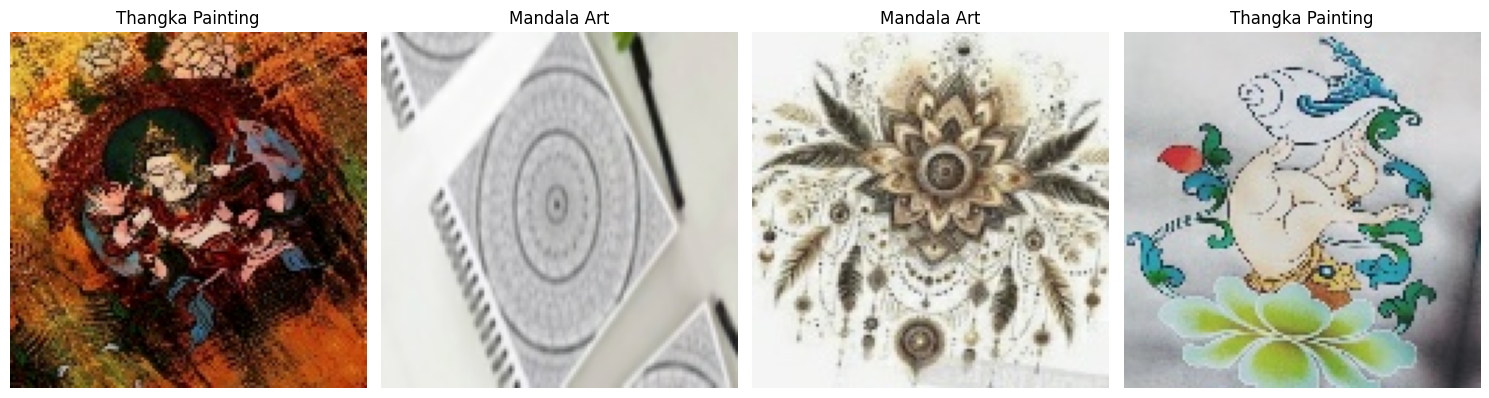

In [12]:
# Fetch a batch of images and labels from the training dataset

images, labels = next(iter(train_dataset))  # `train_dataset` is from the updated pipeline



# Define the number of images to display

num_images = 4

plt.figure(figsize=(15, 10))  # Create a larger figure for better visualization



# Loop through the number of images to display

for index in range(num_images):

    plt.subplot(1, num_images, index + 1)  # Create a subplot for each image

    plt.imshow(images[index].numpy())  # Display the image (convert Tensor to NumPy)

    class_label = labels[index].numpy().argmax()  # Get the class index from one-hot encoding

    class_name = image_labels[class_label]  # Get class name

    plt.title(class_name)  # Set the title to the class name

    plt.axis('off')  # Turn off axis



plt.tight_layout()

plt.show()

In [13]:
base_model = VGG16(include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Freeze pretrained layers

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Another dropout layer for better generalization
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(4, activation='softmax')  # Adjusted for 4 output classes
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Define the log directory

log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))



# Create a TensorBoard callback

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [16]:
early_stopping = EarlyStopping(

    monitor='val_loss',        # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')

    patience=5,                # Number of epochs to wait before stopping

    restore_best_weights=True  # Restores the weights of the best epoch

)

In [17]:
for images, labels in train_dataset.take(1):

    print(f"Image batch shape: {images.shape}")

    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 4)


In [18]:
history = model.fit(

    train_dataset,                # Training dataset

    epochs=30,                    # Adjust epochs as needed

    validation_data=val_dataset,  # Validation dataset

    callbacks=[tensorboard_callback, early_stopping]  # Include callbacks

)

Epoch 1/30


I0000 00:00:1733467720.938114    4699 service.cc:145] XLA service 0x78daa8008920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733467720.938185    4699 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733467733.120821    4699 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1733467733.131632    4699 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


556/556 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4326 - loss: 1.2916

I0000 00:00:1733467785.916976    4699 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads



556/556 ━━━━━━━━━━━━━━━━━━━━ 78s 110ms/step - accuracy: 0.4326 - loss: 1.2914 - val_accuracy: 0.2792 - val_loss: 2.1015
Epoch 2/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.5543 - loss: 0.9899 - val_accuracy: 0.2607 - val_loss: 2.1218
Epoch 3/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.5940 - loss: 0.9047 - val_accuracy: 0.5306 - val_loss: 1.0290
Epoch 4/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.6174 - loss: 0.8634 - val_accuracy: 0.6408 - val_loss: 0.8070
Epoch 5/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.6680 - loss: 0.7679 - val_accuracy: 0.5799 - val_loss: 1.0253
Epoch 6/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.7064 - loss: 0.7011 - val_accuracy: 0.4146 - val_loss: 2.3673
Epoch 7/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.7382 - loss: 0.6330 - val_accuracy: 0.6191 - val_loss: 72.4257
Epoch 8/30
556/556 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.7566 - loss: 0.5932 - val_accur

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.6533 - loss: 0.8196
Test Accuracy: 0.6701461672782898


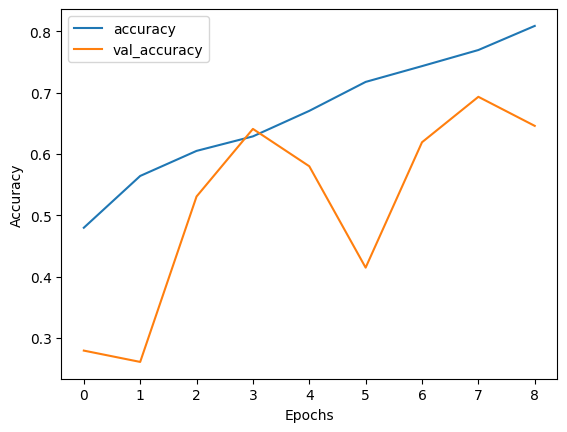

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.show()

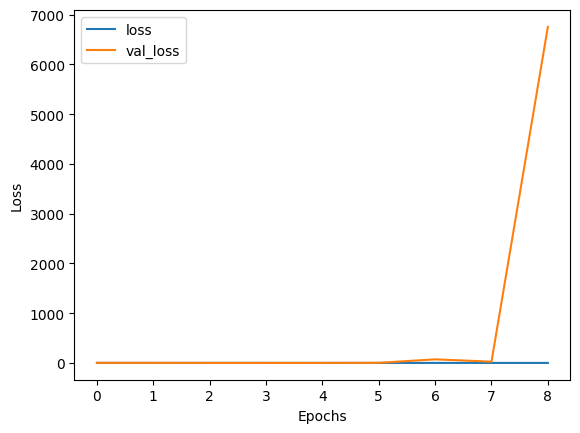

In [21]:
plt.plot(history.history['loss'], label='loss')

plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [22]:
from tensorflow.keras.models import load_model


In [23]:
model.save('art-classification-custom-dataset-c4-v4-4.h5')

In [24]:
# model = load_model('./model/art-classification-v2.h5')

In [25]:
test_images, test_labels = next(iter(test_dataset))

In [26]:
img_predict = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


In [27]:
np.argmax(test_labels[0])

2

In [28]:
np.argmax(img_predict[0])

1

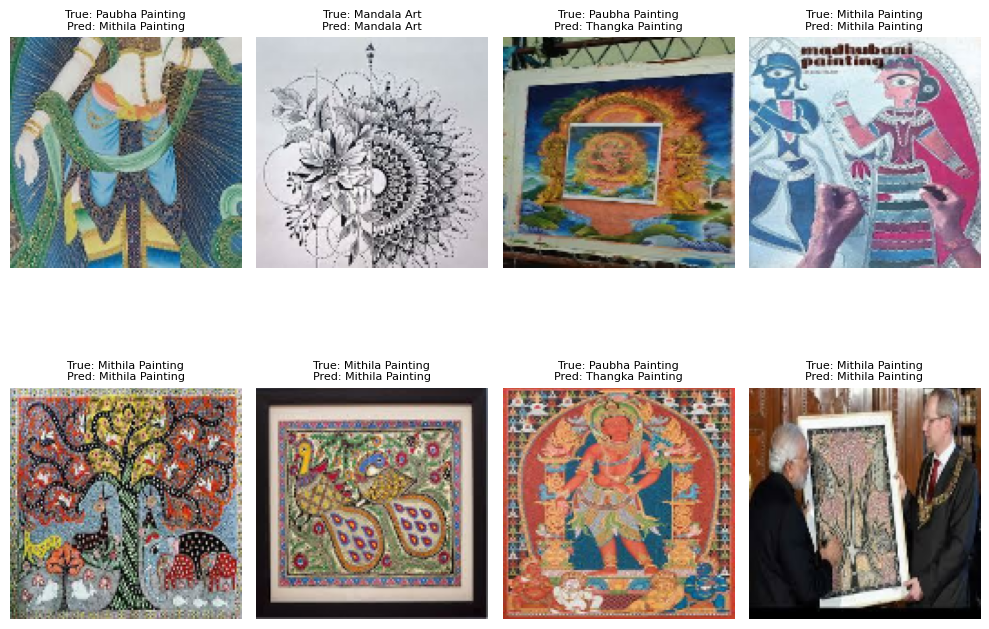

In [29]:
# Plotting

plt.figure(figsize=(10, 8))

for i in range(8):

    plt.subplot(2, 4, i + 1)  # Create a grid of subplots (2 rows, 4 columns)

    plt.imshow(test_images[i], cmap="gray")  # Display the image in grayscale

    

    # Get predicted and true class names

    predicted_class = image_labels[np.argmax(img_predict[i])]

    true_class = image_labels[np.argmax(test_labels[i])]

    

    # Display predicted and true class names

    plt.title(f"True: {true_class}\nPred: {predicted_class}", fontsize=8)

    plt.axis("off")  # Hide axes



plt.tight_layout()

plt.show()
